# BERT for Q/A

Resources:
- Article: https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT/
- Colab: https://colab.research.google.com/drive/1uSlWtJdZmLrI3FCNIlUHFxwAJiSu2J0

In [1]:
%cd ..

/Users/danorel/Workspace/Education/University/KMA/Labs/Computer Linguistics


In [11]:
import torch
import textwrap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from transformers import BertForQuestionAnswering, BertTokenizer

In [3]:
model = BertForQuestionAnswering.from_pretrained(
    "bert-large-uncased-whole-word-masking-finetuned-squad"
)

In [4]:
tokenizer = BertTokenizer.from_pretrained(
    "bert-large-uncased-whole-word-masking-finetuned-squad"
)

In [19]:
# Use plot styling from seaborn.
sns.set(style="darkgrid")

# Increase the plot size and font size.
# sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16, 8)

In [44]:
def answer_question(question, answer_text, visualise=False):
    """
    Takes a `question` string and an `answer_text` string (which contains the
    answer), and identifies the words within the `answer_text` that are the
    answer. Prints them out.
    """
    # ======== Tokenize ========
    # Apply the tokenizer to the input text, treating them as a text-pair.
    input_ids = tokenizer.encode(question, answer_text)

    # Report how long the input sequence is.
    print("Query has {:,} tokens.\n".format(len(input_ids)))

    # ======== Set Segment IDs ========
    # Search the input_ids for the first instance of the `[SEP]` token.
    sep_index = input_ids.index(tokenizer.sep_token_id)

    # The number of segment A tokens includes the [SEP] token istelf.
    num_seg_a = sep_index + 1

    # The remainder are segment B.
    num_seg_b = len(input_ids) - num_seg_a

    # Construct the list of 0s and 1s.
    segment_ids = [0] * num_seg_a + [1] * num_seg_b

    # There should be a segment_id for every input token.
    assert len(segment_ids) == len(input_ids)

    # ======== Evaluate ========
    # Run our example through the model.
    outputs = model(
        torch.tensor([input_ids]),  # The tokens representing our input text.
        token_type_ids=torch.tensor(
            [segment_ids]
        ),  # The segment IDs to differentiate question from answer_text
        return_dict=True,
    )

    start_scores = outputs.start_logits
    end_scores = outputs.end_logits

    # ======== Reconstruct Answer ========
    # Find the tokens with the highest `start` and `end` scores.
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)

    # Get the string versions of the input tokens.
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Start with the first token.
    answer = tokens[answer_start]

    # Select the remaining answer tokens and join them with whitespace.
    for i in range(answer_start + 1, answer_end + 1):

        # If it's a subword token, then recombine it with the previous token.
        if tokens[i][0:2] == "##":
            answer += tokens[i][2:]

        # Otherwise, add a space then the token.
        else:
            answer += " " + tokens[i]

    if visualise:
        # Visualise

        # Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
        s_scores = start_scores.detach().numpy().flatten()
        e_scores = end_scores.detach().numpy().flatten()

        # We'll use the tokens as the x-axis labels. In order to do that, they all need
        # to be unique, so we'll add the token index to the end of each one.
        token_labels = []
        for (i, token) in enumerate(tokens):
            token_labels.append("{:} - {:>2}".format(token, i))

        # Store the tokens and scores in a DataFrame.
        # Each token will have two rows, one for its start score and one for its end
        # score. The "marker" column will differentiate them. A little wacky, I know.
        scores = []
        for (i, token_label) in enumerate(token_labels):

            # Add the token's start score as one row.
            scores.append(
                {"token_label": token_label, "score": s_scores[i], "marker": "start"}
            )

            # Add  the token's end score as another row.
            scores.append(
                {"token_label": token_label, "score": e_scores[i], "marker": "end"}
            )

        df = pd.DataFrame(scores)

        # Draw a grouped barplot to show start and end scores for each word.
        # The "hue" parameter is where we tell it which datapoints belong to which
        # of the two series.
        g = sns.catplot(
            x="token_label",
            y="score",
            hue="marker",
            data=df,
            kind="bar",
            height=6,
            aspect=4,
        )

        # Turn the xlabels vertical.
        g.set_xticklabels(g.ax.get_xticklabels(), rotation=90, ha="center")

        # Turn on the vertical grid to help align words to scores.
        g.ax.grid(True)

        plt.title("Word Scores")

        plt.show()

    return answer

In [45]:
# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80)

bert_abstract = "We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models (Peters et al., 2018a; Radford et al., 2018), BERT is designed to pretrain deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers."

print(wrapper.fill(bert_abstract))

We introduce a new language representation model called BERT, which stands for
Bidirectional Encoder Representations from Transformers. Unlike recent language
representation models (Peters et al., 2018a; Radford et al., 2018), BERT is
designed to pretrain deep bidirectional representations from unlabeled text by
jointly conditioning on both left and right context in all layers.


In [46]:
question = "What does the 'B' in BERT stand for?"
answer_question(question, bert_abstract)

Query has 93 tokens.



'bidirectional encoder representations from transformers'

In [47]:
question = "What are some example applications of BERT?"
answer_question(question, bert_abstract)

Query has 90 tokens.



'pretrain deep bidirectional representations from unlabeled text'

In [48]:
question = "What is the year of BERT publishment?"
answer_question(question, bert_abstract)

Query has 91 tokens.



'2018'

Query has 90 tokens.



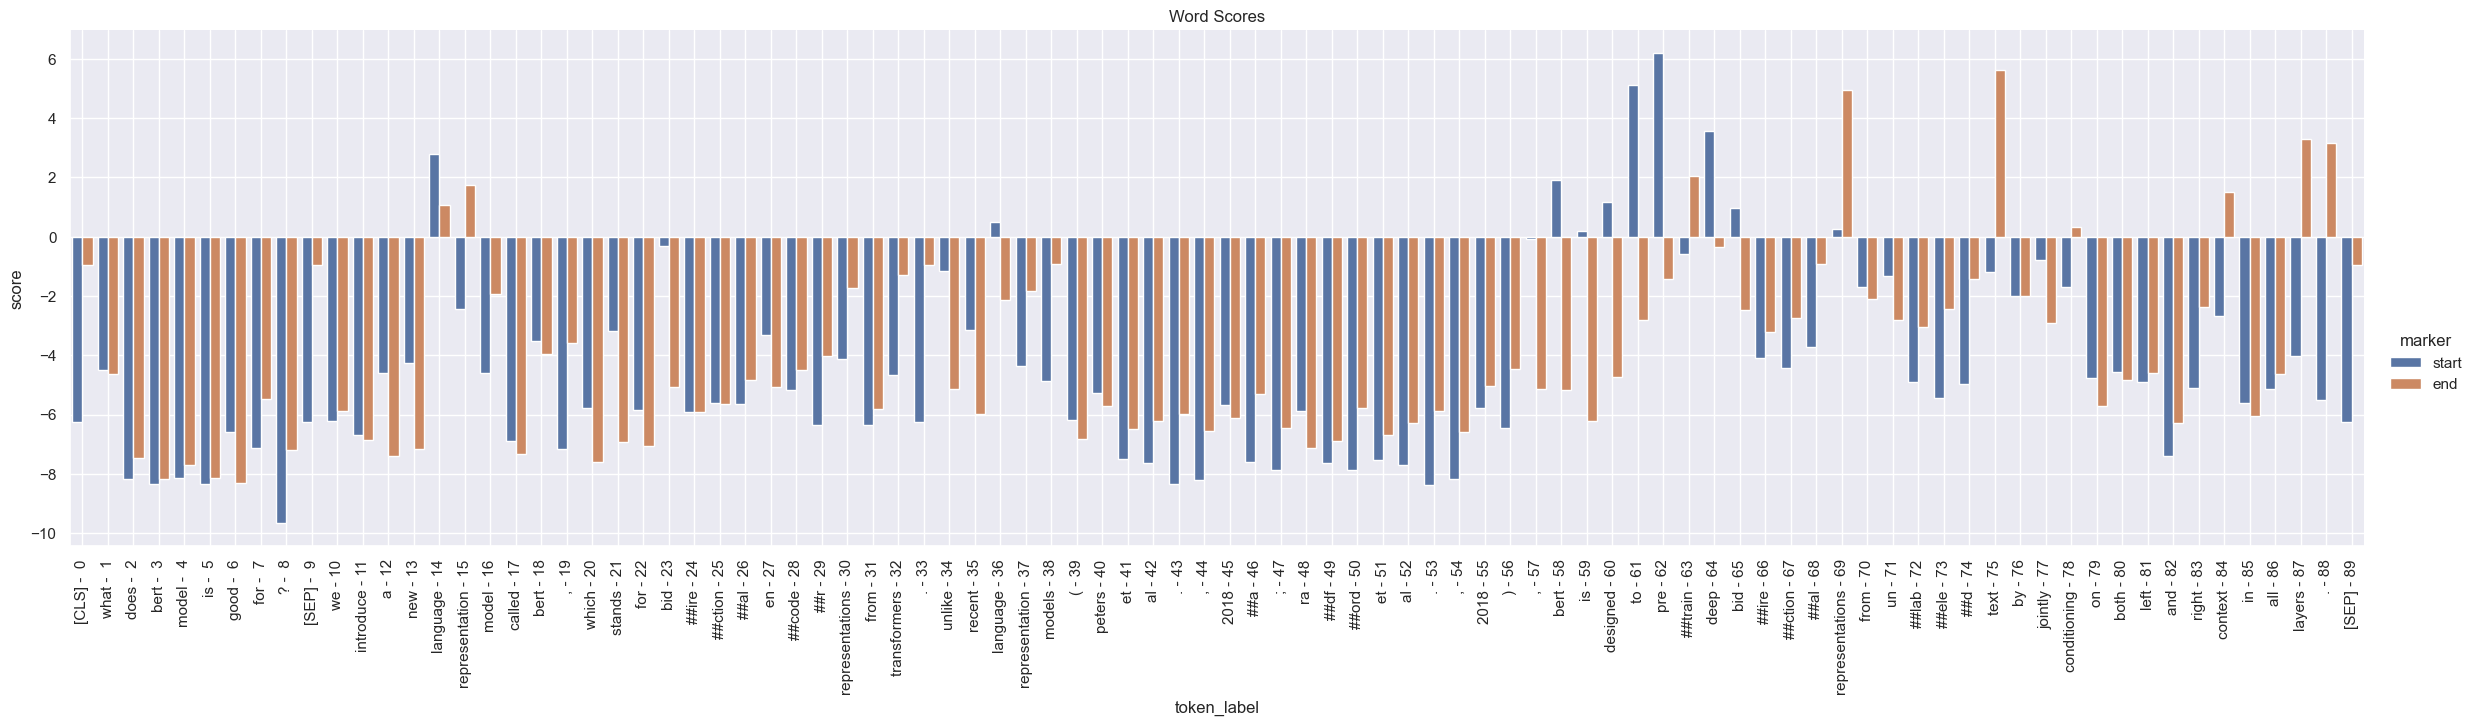

'pretrain deep bidirectional representations from unlabeled text'

In [49]:
question = "What does BERT model is good for?"
answer_question(question, bert_abstract, visualise=True)